In [18]:
from editor import Editor
from Box2D.b2 import pi

# edit your model by running this cell
# to add a body part hit b and it will spawn under your mouse
# to move body parts drag them with the mouse
# to connect body parts, hit p to pin two bodies at the mouse location
# to change a body part's size, click and hold, then use the arrow keys to modify width/height
# hit 's' to save while editing to model.json

editor = Editor()
editor.load('creatures/balance.json')
editor.run()

File saved as: creatures/balance.json


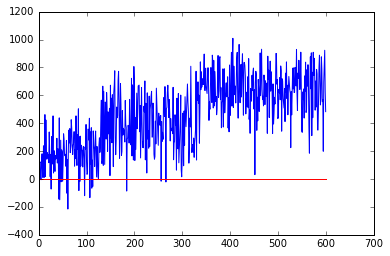

episode: 600 states: 94 memories: 19200 avg_delta: 160.2161 eps: 0.1 lrn_rate: 0.1 avg_visits: 204.255


In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
import pygame
from pygame.locals import (MOUSEBUTTONDOWN, MOUSEBUTTONUP, KEYDOWN, K_RIGHT, K_LEFT, K_UP, K_DOWN, K_r, K_s)
from Box2D.b2 import pi
from engine import Engine
from time import sleep

# train your model to (hopefully) walk by running this cell

# hit s to speed up training, and s again to watch the best set of weights
# use the up and down arrow keys to introduce more or less randomness in weight changes

# this cell is an experiment with policy improvement
# the agent's joint torques (continuous, action) are randomly sampled from means output by a neural network
# the gradient wrt the weights of that network, for that state, are saved each time step
# if the average reward at the end of an episode is positive, we want the agent to act more like it did
# if the reward was negative we want it to act less like it did that episode

FILE = 'creatures/two_legs.json'

FET_STEPS = 16
JOINT_SPEED = 3

# matrix render size
PAD = 12

# Physics engine and window
LOWER_LIM = -.1 * np.pi
UPPER_LIM = .1 * np.pi
LIMIT = True
ANGLE_RANGE = UPPER_LIM - LOWER_LIM if LIMIT else np.pi*2.0

engine = Engine(caption='Train', width=1280, height=720, gravity=(0, -50), joint_limit=LIMIT, \
               upper_angle=UPPER_LIM, lower_angle=LOWER_LIM, max_torque=10000, \
                linear_damping=0.0, angular_damping=0.0)

# Load creature
engine.load(FILE)

# count joints and body parts
body_count = len(engine.bodies)
joint_count = len(engine.joints)

ACTIONS = range(2**joint_count)

if body_count == 0 or joint_count == 0:
    engine.close()
    raise RuntimeError("Your model doesn't have any physics bodies or joints")

def render_matrix(m, p):
    x = p[0]
    y = p[1]
    
    norm = np.clip(m, -1, 1)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            v = norm[i, j]
            if np.abs(v) > 0.001:
                r = int(max(v, 0) * 255)
                b = int(-min(v, 0) * 255)
                engine.draw_rect((x, y, PAD, PAD), 0, (r, 0, b))
            x += PAD
        x = p[0]
        y += PAD
        
def render_matrices(ms):
    sx = 10
    sy = 10
    miniPAD = PAD
    for m in ms:
        render_matrix(m, (sx, sy))
        sx += m.shape[1] * PAD + miniPAD
        
def bit_on(a, bit):
    mask = 2**bit
    return a&mask > 0

def features(time_step=0):
    f = np.zeros([body_count, FET_STEPS])
    
    avg_av = 0.0
    for i, b in enumerate(engine.bodies):
        avg_av += b.angularVelocity
        a = b.angle % (np.pi*2.0)
        a /= (np.pi*2.0)
        a *= FET_STEPS
        idx = int(np.floor(a))
        f[i, idx] = 1
        
    #avg_av /= len(engine.bodies)
    #avg_av = np.clip(avg_av, -FET_STEPS/2, FET_STEPS/2)
    #idx = int(np.floor(avg_av/FET_STEPS))
    #f[body_count, idx] = 1
    
    return f, str(f)

def act(action):
    for i, j in enumerate(engine.joints):
        j.motorSpeed = JOINT_SPEED if bit_on(action, i) else -JOINT_SPEED

class State(object):
    def __init__(self, name):
        self.name = name
        self.qs = np.array([[0.0 for a in ACTIONS]])
        self.visits = 0
        
    def sample_action(self, eps):
        if all(self.qs[0] == self.qs[0, 0]):
            # all equal, random action
            return np.random.choice(ACTIONS)
        dist = [eps/len(ACTIONS) for a in ACTIONS]
        dist[np.argmax(self.qs[0])] += 1.0 - eps
        return np.random.choice(ACTIONS, p=dist)
    
def state(f):
    global state_list
    if f in states:
        return states[f]
    else:
        s = State(f)
        states[f] = s
        state_list += [s]
        return s
        
TIMESTEPS = 30 # timesteps per episode
XP_REPLAY = True # sample memory to train qs further
TRAIN_ITERS = 30000 # times to sample memory to update qs

learning_rate = .1
eps = .3 # 1: full exploration, 0: full exploitation
gamma = 0.998 # discount value of future actions

total_r = 0.0
episode = 0
rs = []
states = {}
state_list = []
state_matrix = np.zeros([32, 32])
M = [] # (S, A, R, S, A) tuples

speedup = False
running = True
interacted = False

while running:
    if not interacted:
        rs += [total_r]
        
    # update state matrix
    idx = 0
    state_matrix[:] = 0.0
    for i in range(state_matrix.shape[0]):
        for j in range(state_matrix.shape[1]):
            if idx < len(state_list):
                s = state_list[idx]
                s.i, s.j = i, j
                state_matrix[i, j] = np.max(s.qs)
                idx += 1
    
    if episode % 100 == 0:
        clear_output(wait=True)
        
        if len(rs) > 1000:
            rs = rs[-1000:]
        
        fig = plt.plot(rs, 'b')
        plt.plot([0, len(rs)], [0, 0], 'r')
        plt.show()
        
        # train on experience
        avg_delta = 0
        if len(M) > 0 and XP_REPLAY:
            for i in range(TRAIN_ITERS):
                xp = M[np.random.randint(0, len(M))]
                _s0, _a0, _r, _s1, _a1 = xp
                delta = (_r + gamma * np.max(_s1.qs) - _s0.qs[0, _a0])
                _s0.qs[0, _a0] += learning_rate * delta
                avg_delta += delta
                
            avg_delta = np.round(avg_delta / TRAIN_ITERS, 4)
        #visits = [s.visits for s in states.values()]
        #plt.plot(visits)
        #plt.show()
        num_states = len(states.keys())
        avg_visits = np.round(np.sum([s.visits for s in states.values()]) / num_states, 3) if num_states > 0 else 0
        print('episode: {} states: {} memories: {} avg_delta: {} eps: {} lrn_rate: {} avg_visits: {}'.format(\
               episode, num_states, len(M), avg_delta, eps, learning_rate, avg_visits))
    
    # new episode
    engine.clear_all_but_ground()
    engine.load(FILE)
    engine.set_position((engine.width/2, engine.height/2))
    
    for j in engine.joints:
        j.motorSpeed = np.random.randn()
    
    engine.step_physics(50)
    for b in engine.bodies:
        b.linearVelocity = (0, 0)
        b.angularVelocity = 0
    
    episode += 1
    
    t = 0
    total_r = 0.0
    
    f, sf = features()
    s0 = state(sf)
    a0 = s0.sample_action(eps)
    
    interacted = False    
    reset = False
    
    while not reset:
        engine.clear_screen()
        
        # keyboard input
        engine.update_mouse()
        for event in engine.events():
            if engine.quit_event(event):
                running = False
                reset = True
            if event.type == KEYDOWN:
                k = pygame.key.get_pressed()
                if k[K_UP]:
                    eps += 0.05
                elif k[K_DOWN]:
                    eps -= 0.05
                elif k[K_s]:
                    speedup = not speedup
                    if not speedup:
                        reset = True
                eps = np.round(eps, 2)
                if eps < 0.0:
                    eps = 0.0
                if eps > 1.0:
                    eps = 1.0
            if event.type == MOUSEBUTTONDOWN:
                engine.create_mouse_joint()
                if engine.mouse_joint:
                    interacted = True
            if event.type == MOUSEBUTTONUP:
                engine.destroy_mouse_joint()
        
        engine.update_mouse_joint()
        
        s0.visits += 1
        
        start_p = engine.body_position()
        
        act(a0)
        
        for i in range(20):
            engine.step_physics(1)
            if not speedup:
                engine.clear_screen()
                render_matrices([f, s0.qs, state_matrix])
                engine.render()
                engine.clock_tick()
                
        end_p = engine.body_position()
        
        # reward
        #reward = -1
        reward = -1 + end_p[0] - start_p[0]

        render_matrix(np.array([[reward]]), (int(end_p[0]), int(end_p[1])))
        
        total_r += reward
        
        f, sf = features()
        s1 = state(sf)
        a1 = s1.sample_action(eps)
        
        if not interacted:
            # train
            s0.qs[0, a0] += learning_rate * (reward + gamma * np.max(s1.qs) - s0.qs[0, a0])

            # remember
            M += [(s0, a0, reward, s1, a1)]
                
        if abs(end_p[0] - engine.width/2) > 400:
            engine.set_position((engine.width/2, end_p[1]), zero_vel=False)

        if t > TIMESTEPS and speedup:
            reset = True
            if (episode+1)%10 == 0:
                render_matrices([f, s0.qs, state_matrix])
                engine.render()
        
        if not speedup:
            render_matrices([f, s0.qs, state_matrix])
            engine.render()
            engine.clock_tick()

        # prepare for next rounds
        t += 1
        
        s0 = s1
        a0 = a1

engine.close()